# RL example for Regularity Normalization (RN)
---
In this notebook, we demonstrated the empirical performances a DQN agent with or without RN with OpenAI Gym's LunarLander-v2 environment.

### 1. Import the Necessary Packages

In [1]:
import gym
import random
import torch
import numpy as np
import math 
from collections import deque
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

### 2. Instantiate the Environment and Agent

Initialize the environment

In [2]:
env = gym.make('CartPole-v1')
env.seed(0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (4,)
Number of actions:  2


Here we specify the agent to use:

In [3]:
from dqn_agent import Agent,Agent_UAM

agent = Agent(state_size=4, action_size=2, seed=0,qnet='DQN-RNLN')

# watch an untrained agent
state = env.reset()
for j in range(200):
    action = agent.act(state)
    env.render()
    state, reward, done, _ = env.step(action)
    if done:
        break 
        
env.close()

### 3. Train the Agent with DQN variants

Train the agents from scratch. 

In [4]:
def dqn(agentName, n_episodes=1000, max_t=1000,eps_start=1.0, eps_end=0.01, eps_decay=0.95, runs=10):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """

    scores_runs = 0*np.ndarray((runs,n_episodes)) # containing scores for each runs
    window_size = 10
    eps = eps_start                               # initialize epsilon
    solved = []
    for run in np.arange(runs):
        scores_window = deque(maxlen=window_size)             # last n scores
        agent = Agent(state_size=4, action_size=2, seed=run, qnet=agentName)
        firstPast = True
        scores = []                               # list containing scores from each episode
        for i_episode in range(1, n_episodes+1):
            state = env.reset()
            score = 0
            for t in range(max_t):
                action = agent.act(state, eps)
                next_state, reward, done, _ = env.step(action)
                agent.step(state, action, reward, next_state, done)
                state = next_state
                score += reward
                if done:
                    break 
            scores_window.append(score)       # save most recent score
            scores.append(score)              # save most recent score
            eps = max(eps_end, eps_decay*eps) # decrease epsilon
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
            if i_episode % 100 == 0:
                print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            if np.mean(scores_window)>=200.0 and firstPast:
                firstPast = False
                solved.append(i_episode-window_size)
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-window_size, np.mean(scores_window)))
                # torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
                # break
        scores_runs[run,:]=scores
    return scores_runs,np.array(solved)


In [5]:
def dqn_uam(agentName, n_episodes=1000, max_t=1000,eps_start=1.0, eps_end=0.01, eps_decay=0.95, runs=1):
    """Deep Q-Learning - Unsupervised Attention Mechanism
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """

    scores_runs = 0*np.ndarray((runs,n_episodes)) # containing scores for each runs
    window_size = 50
    eps = eps_start                               # initialize epsilon
    solved = []
    MDL_local, MDL_target = [], []
    for run in np.arange(runs):
        MDL_local, MDL_target = [], []

        scores_window = deque(maxlen=window_size)             # last n scores
        agent = Agent_UAM(state_size=4, action_size=2, seed=run, qnet=agentName)
        firstPast = True
        scores = []                               # list containing scores from each episode
        for i_episode in range(1, n_episodes+1):
            state = env.reset()
            score = 0
            for t in range(max_t):
                action = agent.act(state, eps)
                next_state, reward, done, _ = env.step(action)
                l_local, l_target = agent.step(state, action, reward, next_state, done)
                if l_local != -1:
                    MDL_local.append(l_local)
                    MDL_target.append(l_target)
                state = next_state
                score += reward
                if done:
                    break 
            scores_window.append(score)       # save most recent score
            scores.append(score)              # save most recent score
            eps = max(eps_end, eps_decay*eps) # decrease epsilon
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
            if i_episode % 100 == 0:
                print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            if np.mean(scores_window)>=200.0 and firstPast:
                firstPast = False
                solved.append(i_episode-window_size)
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-window_size, np.mean(scores_window)))
                # torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
                # break
        scores_runs[run,:]=scores
    return scores_runs,np.array(solved),MDL_local,MDL_target


In [6]:
n = 50   # runs
m = 2000  # episodes
alpha = 0.1


In [79]:
print('--------------------------')
print('DQN')
scores1,solved1 = dqn('DQN',n_episodes=m,runs=n)
np.save('./scores/carpole_dqn.npy',scores1)
np.save('./scores/carpole_dqn_solved.npy',solved1)

print('--------------------------')
print('DQN-LN')
scores2,solved2 = dqn('DQN-LN',n_episodes=m,runs=n)
np.save('./scores/carpole_dqnln.npy',scores2)
np.save('./scores/carpole_dqnln_solved.npy', solved2)

print('--------------------------')
print('DQN-RN')
scores3,solved3 = dqn('DQN-RN',n_episodes=m,runs=n)
np.save('./scores/carpole_dqnrn.npy',scores3)
np.save('./scores/carpole_dqnrn_solved.npy', solved3)

print('--------------------------')
print('DQN-RLN')
scores4,solved4 = dqn('DQN-RLN',n_episodes=m,runs=n)
np.save('./scores/carpole_dqnrln.npy',scores4)
np.save('./scores/carpole_dqnrln_solved', solved4)

print('--------------------------')
print('DQN-RNLN')
scores5,solved5 = dqn('DQN-RNLN',n_episodes=m,runs=n)
np.save('./scores/carpole_dqnrnln.npy',scores5)
np.save('./scores/carpole_dqnrnln_solved.npy', solved5)


--------------------------
DQN
--------------------------
DQN-LN
--------------------------
DQN-RN
--------------------------
DQN-RLN
--------------------------
DQN-RNLN


DQN scores  162.77120000000002  +/-  13.777968479104603
DQN+LN scores  159.084  +/-  8.39813257337606
DQN+RN scores  193.12199999999996  +/-  14.054907086138991
DQN+RLN scores  156.3504  +/-  12.450290820571219
DQN+RN+LN scores  206.98719999999997  +/-  10.04023408109592


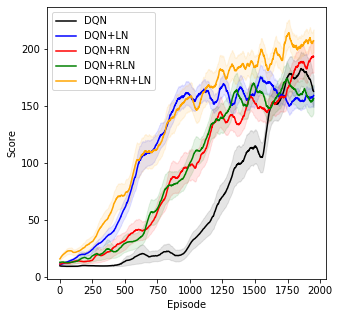

In [71]:
# plot the scores
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)


scores1_full = np.load('./scores/carpole_dqn.npy',allow_pickle=True)
scores2_full = np.load('./scores/carpole_dqnln.npy',allow_pickle=True)
scores3_full = np.load('./scores/carpole_dqnrn.npy',allow_pickle=True)
scores4_full = np.load('./scores/carpole_dqnrln.npy',allow_pickle=True)
scores5_full = np.load('./scores/carpole_dqnrnln.npy',allow_pickle=True)
T = np.arange(m)

alpha = 0.1

MA = 50
maxT = np.min([scores1_full.shape[1],scores2_full.shape[1],scores3_full.shape[1],scores4_full.shape[1],scores5_full.shape[1]])
T = np.arange(maxT-MA+1)

scores1 = np.zeros((n,maxT-MA+1))
scores2 = np.zeros((n,maxT-MA+1))
scores3 = np.zeros((n,maxT-MA+1))
scores4 = np.zeros((n,maxT-MA+1))
scores5 = np.zeros((n,maxT-MA+1))
for tr in np.arange(n):
    scores1[tr] = pd.Series(scores1_full[tr,:maxT]).rolling(window=MA).mean().iloc[MA-1:].values
    scores2[tr] = pd.Series(scores2_full[tr,:maxT]).rolling(window=MA).mean().iloc[MA-1:].values
    scores3[tr] = pd.Series(scores3_full[tr,:maxT]).rolling(window=MA).mean().iloc[MA-1:].values
    scores4[tr] = pd.Series(scores4_full[tr,:maxT]).rolling(window=MA).mean().iloc[MA-1:].values
    scores5[tr] = pd.Series(scores5_full[tr,:maxT]).rolling(window=MA).mean().iloc[MA-1:].values

ax.plot(T, np.mean(scores1,0),color='black',label='DQN')
ax.plot(T, np.mean(scores2,0),color='blue',label='DQN+LN')
ax.plot(T, np.mean(scores3,0),color='red',label='DQN+RN')
ax.plot(T, np.mean(scores4,0),color='green',label='DQN+RLN')
ax.plot(T, np.mean(scores5,0),color='orange',label='DQN+RN+LN')

ax.fill_between(T, np.mean(scores1,0)-np.std(scores1,0)/math.sqrt(n),np.mean(scores1,0)+np.std(scores1,0)/math.sqrt(n),alpha=alpha,color='black')
ax.fill_between(T, np.mean(scores2,0)-np.std(scores2,0)/math.sqrt(n),np.mean(scores2,0)+np.std(scores2,0)/math.sqrt(n),alpha=alpha,color='blue')
ax.fill_between(T, np.mean(scores3,0)-np.std(scores3,0)/math.sqrt(n),np.mean(scores3,0)+np.std(scores3,0)/math.sqrt(n),alpha=alpha,color='red')
ax.fill_between(T, np.mean(scores4,0)-np.std(scores4,0)/math.sqrt(n),np.mean(scores4,0)+np.std(scores4,0)/math.sqrt(n),alpha=alpha,color='green')
ax.fill_between(T, np.mean(scores5,0)-np.std(scores5,0)/math.sqrt(n),np.mean(scores5,0)+np.std(scores5,0)/math.sqrt(n),alpha=alpha,color='orange')

ax.set_ylabel('Score')
ax.set_xlabel('Episode')
ax.legend()

fig.savefig('carpole_scores.png')

print('DQN scores ', np.mean(scores1[:,-1]), ' +/- ',np.std(scores1[:,-1])/math.sqrt(n))
print('DQN+LN scores ', np.mean(scores2[:,-1]), ' +/- ',np.std(scores2[:,-1])/math.sqrt(n))
print('DQN+RN scores ', np.mean(scores3[:,-1]), ' +/- ',np.std(scores3[:,-1])/math.sqrt(n))
print('DQN+RLN scores ', np.mean(scores4[:,-1]), ' +/- ',np.std(scores4[:,-1])/math.sqrt(n))
print('DQN+RN+LN scores ', np.mean(scores5[:,-1]), ' +/- ',np.std(scores5[:,-1])/math.sqrt(n))

# print('DQN solves in ', np.mean(solved1), ' +/- ',np.std(solved1)/math.sqrt(n))
# print('DQN+LN solves in ', np.mean(solved2), ' +/- ',np.std(solved2)/math.sqrt(n))
# print('DQN+RN solves in ', np.mean(solved3), ' +/- ',np.std(solved3)/math.sqrt(n))
# print('DQN+RLN solves  in ', np.mean(solved4), ' +/- ',np.std(solved4)/math.sqrt(n))
# print('DQN+RN+LN solves in ', np.mean(solved5), ' +/- ',np.std(solved5)/math.sqrt(n))

In [5]:
n = 1    # runs
m = 2000  # episodes
alpha = 0.1


In [7]:
print('--------------------------')
print('DQN')
scores1,solved1,MDL_local1,MDL_target1 = dqn_uam('DQN-UAM',n_episodes=m,runs=n)
np.save('./scores/carpole_dqn_mdl_local.npy',MDL_local1)
np.save('./scores/carpole_dqn_mdl_target.npy',MDL_target1)


--------------------------
DQN
Episode 100	Average Score: 9.72
Episode 200	Average Score: 9.50
Episode 300	Average Score: 9.46
Episode 400	Average Score: 9.44
Episode 500	Average Score: 9.56
Episode 600	Average Score: 9.50
Episode 700	Average Score: 9.42
Episode 800	Average Score: 9.746
Episode 900	Average Score: 10.60
Episode 1000	Average Score: 10.44
Episode 1100	Average Score: 15.02
Episode 1200	Average Score: 11.74
Episode 1300	Average Score: 30.08
Episode 1350	Average Score: 200.06
Environment solved in 1300 episodes!	Average Score: 200.06
Episode 1400	Average Score: 267.24
Episode 1500	Average Score: 235.84
Episode 1600	Average Score: 430.00
Episode 1700	Average Score: 165.00
Episode 1800	Average Score: 180.22
Episode 1900	Average Score: 13.786
Episode 2000	Average Score: 19.20


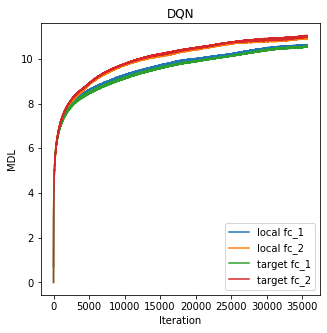

In [5]:
MDL_local = np.load('./scores/carpole_dqn_mdl_local.npy',allow_pickle=True)
MDL_target = np.load('./scores/carpole_dqn_mdl_target.npy',allow_pickle=True)

MDL_local, MDL_target = np.array(MDL_local), np.array(MDL_target)
T = np.arange(MDL_local.shape[0])

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

ax.plot(T, MDL_local[:,1],label='local fc_1')
ax.plot(T, MDL_local[:,2],label='local fc_2')
ax.plot(T, MDL_target[:,1],label='target fc_1')
ax.plot(T, MDL_target[:,2],label='target fc_2')

ax.set_ylabel('MDL')
ax.set_xlabel('Iteration')
ax.legend()
ax.set_title('DQN')

fig.savefig('uam_carpole_dqn.png',layout='tight')


In [8]:
print('--------------------------')
print('DQN+RN')
scores3,solved3,MDL_local3,MDL_target3 = dqn_uam('DQN-RN-UAM',n_episodes=m,runs=n)
np.save('./scores/carpole_dqnrn_mdl_local.npy',MDL_local3)
np.save('./scores/carpole_dqnrn_mdl_target.npy',MDL_target3)


--------------------------
DQN+RN
Episode 100	Average Score: 11.60
Episode 200	Average Score: 11.20
Episode 300	Average Score: 10.76
Episode 400	Average Score: 12.34
Episode 500	Average Score: 13.82
Episode 600	Average Score: 13.82
Episode 700	Average Score: 13.32
Episode 800	Average Score: 9.862
Episode 900	Average Score: 14.36
Episode 1000	Average Score: 71.36
Episode 1100	Average Score: 126.22
Episode 1179	Average Score: 201.00
Environment solved in 1129 episodes!	Average Score: 201.00
Episode 1200	Average Score: 243.64
Episode 1300	Average Score: 140.22
Episode 1400	Average Score: 127.94
Episode 1500	Average Score: 279.62
Episode 1600	Average Score: 176.00
Episode 1700	Average Score: 160.24
Episode 1800	Average Score: 318.88
Episode 1900	Average Score: 332.88
Episode 2000	Average Score: 371.28


/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


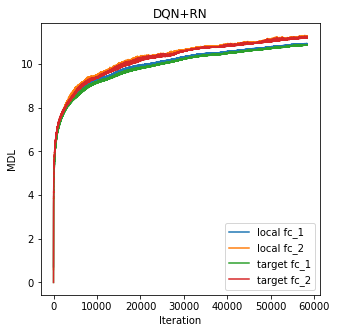

In [9]:
MDL_local = np.load('./scores/carpole_dqnrn_mdl_local.npy',allow_pickle=True)
MDL_target = np.load('./scores/carpole_dqnrn_mdl_target.npy',allow_pickle=True)

MDL_local, MDL_target = np.array(MDL_local), np.array(MDL_target)
T = np.arange(MDL_local.shape[0])

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

ax.plot(T, MDL_local[:,1],label='local fc_1')
ax.plot(T, MDL_local[:,2],label='local fc_2')
ax.plot(T, MDL_target[:,1],label='target fc_1')
ax.plot(T, MDL_target[:,2],label='target fc_2')

ax.set_ylabel('MDL')
ax.set_xlabel('Iteration')
ax.legend()
ax.set_title('DQN+RN')

fig.savefig('uam_carpole_dqnrn.png',layout='tight')


In [10]:
print('--------------------------')
print('DQN+RLN')
scores4,solved4,MDL_local4,MDL_target4 = dqn_uam('DQN-RLN-UAM',n_episodes=m,runs=n)
np.save('./scores/carpole_dqnrln_mdl_local.npy',MDL_local4)
np.save('./scores/carpole_dqnrln_mdl_target.npy',MDL_target4)


--------------------------
DQN+RLN
Episode 100	Average Score: 10.74
Episode 200	Average Score: 9.786
Episode 300	Average Score: 11.06
Episode 400	Average Score: 13.72
Episode 500	Average Score: 17.28
Episode 600	Average Score: 25.74
Episode 700	Average Score: 24.90
Episode 800	Average Score: 22.76
Episode 900	Average Score: 23.86
Episode 1000	Average Score: 127.54
Episode 1078	Average Score: 202.76
Environment solved in 1028 episodes!	Average Score: 202.76
Episode 1100	Average Score: 290.44
Episode 1200	Average Score: 190.80
Episode 1300	Average Score: 451.42
Episode 1400	Average Score: 368.02
Episode 1500	Average Score: 343.88
Episode 1600	Average Score: 238.34
Episode 1700	Average Score: 247.76
Episode 1800	Average Score: 174.72
Episode 1900	Average Score: 221.20
Episode 2000	Average Score: 172.72


/Users/DoerLBH/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


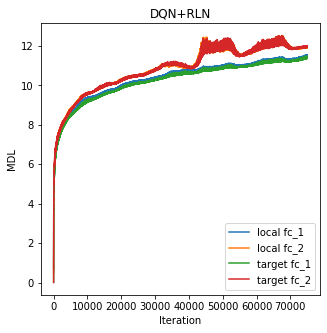

In [11]:
MDL_local = np.load('./scores/carpole_dqnrln_mdl_local.npy',allow_pickle=True)
MDL_target = np.load('./scores/carpole_dqnrln_mdl_target.npy',allow_pickle=True)

MDL_local, MDL_target = np.array(MDL_local), np.array(MDL_target)
T = np.arange(MDL_local.shape[0])

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

ax.plot(T, MDL_local[:,1],label='local fc_1')
ax.plot(T, MDL_local[:,2],label='local fc_2')
ax.plot(T, MDL_target[:,1],label='target fc_1')
ax.plot(T, MDL_target[:,2],label='target fc_2')

ax.set_ylabel('MDL')
ax.set_xlabel('Iteration')
ax.legend()
ax.set_title('DQN+RLN')

fig.savefig('uam_carpole_dqnrln.png',layout='tight')


In [12]:
print('--------------------------')
print('DQN+LN')
scores2,solved2,MDL_local2,MDL_target2 = dqn_uam('DQN-LN-UAM',n_episodes=m,runs=n)
np.save('./scores/carpole_dqnln_mdl_local.npy',MDL_local2)
np.save('./scores/carpole_dqnln_mdl_target.npy',MDL_target2)


--------------------------
DQN+LN
Episode 100	Average Score: 14.88
Episode 200	Average Score: 13.40
Episode 300	Average Score: 13.66
Episode 400	Average Score: 14.58
Episode 500	Average Score: 16.86
Episode 600	Average Score: 22.20
Episode 700	Average Score: 25.02
Episode 800	Average Score: 89.88
Episode 845	Average Score: 204.62
Environment solved in 795 episodes!	Average Score: 204.62
Episode 900	Average Score: 191.18
Episode 1000	Average Score: 117.50
Episode 1100	Average Score: 115.00
Episode 1200	Average Score: 101.82
Episode 1300	Average Score: 109.28
Episode 1400	Average Score: 185.42
Episode 1500	Average Score: 136.46
Episode 1600	Average Score: 130.32
Episode 1700	Average Score: 182.72
Episode 1800	Average Score: 141.00
Episode 1900	Average Score: 144.16
Episode 2000	Average Score: 149.58


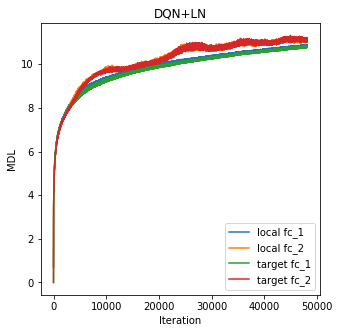

In [13]:
MDL_local = np.load('./scores/carpole_dqnln_mdl_local.npy',allow_pickle=True)
MDL_target = np.load('./scores/carpole_dqnln_mdl_target.npy',allow_pickle=True)

MDL_local, MDL_target = np.array(MDL_local), np.array(MDL_target)
T = np.arange(MDL_local.shape[0])

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

ax.plot(T, MDL_local[:,1],label='local fc_1')
ax.plot(T, MDL_local[:,2],label='local fc_2')
ax.plot(T, MDL_target[:,1],label='target fc_1')
ax.plot(T, MDL_target[:,2],label='target fc_2')

ax.set_ylabel('MDL')
ax.set_xlabel('Iteration')
ax.legend()
ax.set_title('DQN+LN')

fig.savefig('uam_carpole_dqnln.png',layout='tight')


In [6]:
print('--------------------------')
print('DQN+RN+LN')
scores5,solved5,MDL_local5,MDL_target5 = dqn_uam('DQN-RNLN-UAM',n_episodes=m,runs=n)
np.save('./scores/carpole_dqnrnln_mdl_local.npy',MDL_local5)
np.save('./scores/carpole_dqnrnln_mdl_target.npy',MDL_target5)


--------------------------
DQN+RN+LN
Episode 100	Average Score: 16.36
Episode 200	Average Score: 12.34
Episode 300	Average Score: 13.70
Episode 400	Average Score: 14.16
Episode 500	Average Score: 13.74
Episode 600	Average Score: 14.08
Episode 700	Average Score: 15.42
Episode 800	Average Score: 14.42
Episode 900	Average Score: 22.50
Episode 1000	Average Score: 23.66
Episode 1100	Average Score: 84.74
Episode 1200	Average Score: 160.42
Episode 1300	Average Score: 142.02
Episode 1400	Average Score: 139.50
Episode 1500	Average Score: 170.60
Episode 1534	Average Score: 201.08
Environment solved in 1484 episodes!	Average Score: 201.08
Episode 1600	Average Score: 151.12
Episode 1700	Average Score: 202.60
Episode 1800	Average Score: 229.60
Episode 1900	Average Score: 263.26
Episode 2000	Average Score: 133.74


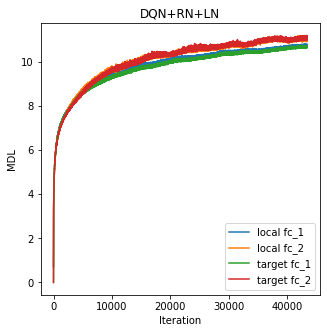

In [7]:
MDL_local = np.load('./scores/carpole_dqnrnln_mdl_local.npy',allow_pickle=True)
MDL_target = np.load('./scores/carpole_dqnrnln_mdl_target.npy',allow_pickle=True)

MDL_local, MDL_target = np.array(MDL_local), np.array(MDL_target)
T = np.arange(MDL_local.shape[0])

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

ax.plot(T, MDL_local[:,1],label='local fc_1')
ax.plot(T, MDL_local[:,2],label='local fc_2')
ax.plot(T, MDL_target[:,1],label='target fc_1')
ax.plot(T, MDL_target[:,2],label='target fc_2')

ax.set_ylabel('MDL')
ax.set_xlabel('Iteration')
ax.legend()
ax.set_title('DQN+RN+LN')

fig.savefig('uam_carpole_dqnrnln.png',layout='tight')


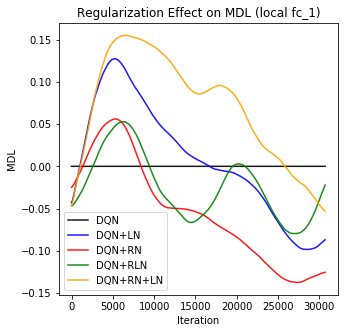

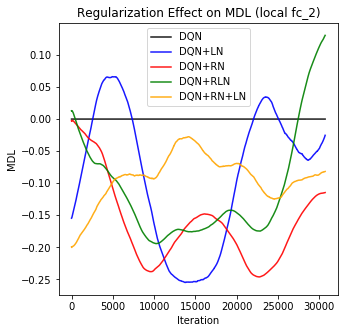

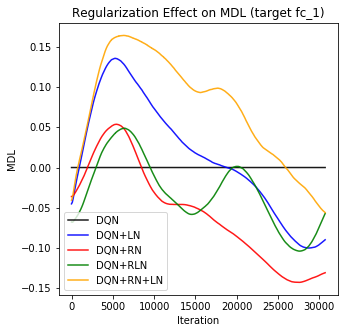

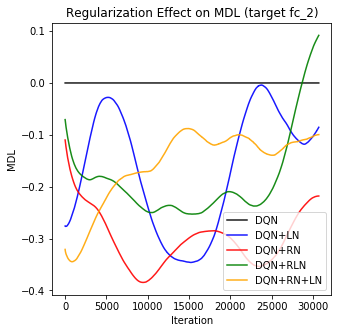

In [2]:
MDL_local1 = np.array(np.load('./scores/carpole_dqn_mdl_local.npy',allow_pickle=True))
MDL_target1 = np.array(np.load('./scores/carpole_dqn_mdl_target.npy',allow_pickle=True))
MDL_local2 = np.array(np.load('./scores/carpole_dqnln_mdl_local.npy',allow_pickle=True))
MDL_target2 = np.array(np.load('./scores/carpole_dqnln_mdl_target.npy',allow_pickle=True))
MDL_local3 = np.array(np.load('./scores/carpole_dqnrn_mdl_local.npy',allow_pickle=True))
MDL_target3 = np.array(np.load('./scores/carpole_dqnrn_mdl_target.npy',allow_pickle=True))
MDL_local4 = np.array(np.load('./scores/carpole_dqnrln_mdl_local.npy',allow_pickle=True))
MDL_target4 = np.array(np.load('./scores/carpole_dqnrln_mdl_target.npy',allow_pickle=True))
MDL_local5 = np.array(np.load('./scores/carpole_dqnrnln_mdl_local.npy',allow_pickle=True))
MDL_target5 = np.array(np.load('./scores/carpole_dqnrnln_mdl_target.npy',allow_pickle=True))

MA = 5000
maxT = np.min([MDL_local1.shape[0],MDL_local2.shape[0],MDL_local3.shape[0],MDL_local4.shape[0],MDL_local5.shape[0]])
T = np.arange(maxT-MA+1)

l1_fc1 = pd.Series(MDL_local1[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
l2_fc1 = pd.Series(MDL_local2[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
l3_fc1 = pd.Series(MDL_local3[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
l4_fc1 = pd.Series(MDL_local4[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
l5_fc1 = pd.Series(MDL_local5[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
t1_fc1 = pd.Series(MDL_target1[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
t2_fc1 = pd.Series(MDL_target2[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
t3_fc1 = pd.Series(MDL_target3[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
t4_fc1 = pd.Series(MDL_target4[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
t5_fc1 = pd.Series(MDL_target5[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
l1_fc2 = pd.Series(MDL_local1[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
l2_fc2 = pd.Series(MDL_local2[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
l3_fc2 = pd.Series(MDL_local3[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
l4_fc2 = pd.Series(MDL_local4[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
l5_fc2 = pd.Series(MDL_local5[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
t1_fc2 = pd.Series(MDL_target1[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
t2_fc2 = pd.Series(MDL_target2[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
t3_fc2 = pd.Series(MDL_target3[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
t4_fc2 = pd.Series(MDL_target4[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
t5_fc2 = pd.Series(MDL_target5[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values


alpha = 0.9                       
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

ax.plot(T, l1_fc1-l1_fc1,label='DQN',color='black',alpha=alpha)
ax.plot(T, l2_fc1-l1_fc1,label='DQN+LN',color='blue',alpha=alpha)
ax.plot(T, l3_fc1-l1_fc1,label='DQN+RN',color='red',alpha=alpha)
ax.plot(T, l4_fc1-l1_fc1,label='DQN+RLN',color='green',alpha=alpha)
ax.plot(T, l5_fc1-l1_fc1,label='DQN+RN+LN',color='orange',alpha=alpha)

ax.set_ylabel('MDL')
ax.set_xlabel('Iteration')
ax.legend()
ax.set_title('Regularization Effect on MDL (local fc_1)')

fig.savefig('uam_carpole_local_fc_1.png',layout='tight')


fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

ax.plot(T, l1_fc2-l1_fc2,label='DQN',color='black',alpha=alpha)
ax.plot(T, l2_fc2-l1_fc2,label='DQN+LN',color='blue',alpha=alpha)
ax.plot(T, l3_fc2-l1_fc2,label='DQN+RN',color='red',alpha=alpha)
ax.plot(T, l4_fc2-l1_fc2,label='DQN+RLN',color='green',alpha=alpha)
ax.plot(T, l5_fc2-l1_fc2,label='DQN+RN+LN',color='orange',alpha=alpha)

ax.set_ylabel('MDL')
ax.set_xlabel('Iteration')
ax.legend()
ax.set_title('Regularization Effect on MDL (local fc_2)')

fig.savefig('uam_carpole_local_fc_2.png',layout='tight')

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

ax.plot(T, t1_fc1-t1_fc1,label='DQN',color='black',alpha=alpha)
ax.plot(T, t2_fc1-t1_fc1,label='DQN+LN',color='blue',alpha=alpha)
ax.plot(T, t3_fc1-t1_fc1,label='DQN+RN',color='red',alpha=alpha)
ax.plot(T, t4_fc1-t1_fc1,label='DQN+RLN',color='green',alpha=alpha)
ax.plot(T, t5_fc1-t1_fc1,label='DQN+RN+LN',color='orange',alpha=alpha)

ax.set_ylabel('MDL')
ax.set_xlabel('Iteration')
ax.legend()
ax.set_title('Regularization Effect on MDL (target fc_1)')

fig.savefig('uam_carpole_target_fc_1.png',layout='tight')


fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

ax.plot(T, t1_fc2-t1_fc2,label='DQN',color='black',alpha=alpha)
ax.plot(T, t2_fc2-t1_fc2,label='DQN+LN',color='blue',alpha=alpha)
ax.plot(T, t3_fc2-t1_fc2,label='DQN+RN',color='red',alpha=alpha)
ax.plot(T, t4_fc2-t1_fc2,label='DQN+RLN',color='green',alpha=alpha)
ax.plot(T, t5_fc2-t1_fc2,label='DQN+RN+LN',color='orange',alpha=alpha)

ax.set_ylabel('MDL')
ax.set_xlabel('Iteration')
ax.legend()
ax.set_title('Regularization Effect on MDL (target fc_2)')

fig.savefig('uam_carpole_target_fc_2.png',layout='tight')

In [53]:
maxT

35697

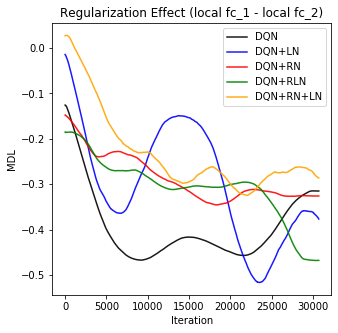

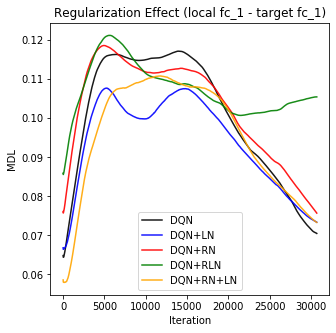

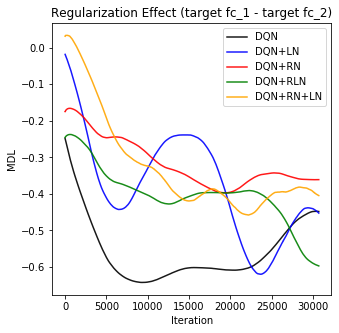

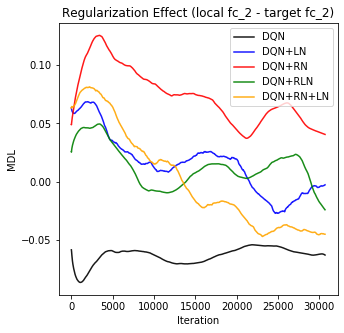

In [73]:
# MDL_local1 = np.array(np.load('./scores/carpole_dqn_mdl_local.npy',allow_pickle=True))
# MDL_target1 = np.array(np.load('./scores/carpole_dqn_mdl_target.npy',allow_pickle=True))
# MDL_local2 = np.array(np.load('./scores/carpole_dqnln_mdl_local.npy',allow_pickle=True))
# MDL_target2 = np.array(np.load('./scores/carpole_dqnln_mdl_target.npy',allow_pickle=True))
# MDL_local3 = np.array(np.load('./scores/carpole_dqnrn_mdl_local.npy',allow_pickle=True))
# MDL_target3 = np.array(np.load('./scores/carpole_dqnrn_mdl_target.npy',allow_pickle=True))
# MDL_local4 = np.array(np.load('./scores/carpole_dqnrln_mdl_local.npy',allow_pickle=True))
# MDL_target4 = np.array(np.load('./scores/carpole_dqnrln_mdl_target.npy',allow_pickle=True))
# MDL_local5 = np.array(np.load('./scores/carpole_dqnrnln_mdl_local.npy',allow_pickle=True))
# MDL_target5 = np.array(np.load('./scores/carpole_dqnrnln_mdl_target.npy',allow_pickle=True))

# MA = 500
# maxT = np.min([MDL_local1.shape[0],MDL_local2.shape[0],MDL_local3.shape[0],MDL_local4.shape[0],MDL_local5.shape[0]])
# T = np.arange(maxT-MA+1)

# l1_fc1 = pd.Series(MDL_local1[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# l2_fc1 = pd.Series(MDL_local2[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# l3_fc1 = pd.Series(MDL_local3[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# l4_fc1 = pd.Series(MDL_local4[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# l5_fc1 = pd.Series(MDL_local5[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# t1_fc1 = pd.Series(MDL_target1[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# t2_fc1 = pd.Series(MDL_target2[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# t3_fc1 = pd.Series(MDL_target3[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# t4_fc1 = pd.Series(MDL_target4[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# t5_fc1 = pd.Series(MDL_target5[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# l1_fc2 = pd.Series(MDL_local1[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
# l2_fc2 = pd.Series(MDL_local2[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
# l3_fc2 = pd.Series(MDL_local3[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
# l4_fc2 = pd.Series(MDL_local4[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
# l5_fc2 = pd.Series(MDL_local5[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
# t1_fc2 = pd.Series(MDL_target1[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
# t2_fc2 = pd.Series(MDL_target2[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
# t3_fc2 = pd.Series(MDL_target3[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
# t4_fc2 = pd.Series(MDL_target4[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
# t5_fc2 = pd.Series(MDL_target5[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values

alpha = 0.9

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

ax.plot(T, l1_fc1-l1_fc2,label='DQN',color='black',alpha=alpha)
ax.plot(T, l2_fc1-l2_fc2,label='DQN+LN',color='blue',alpha=alpha)
ax.plot(T, l3_fc1-l3_fc2,label='DQN+RN',color='red',alpha=alpha)
ax.plot(T, l4_fc1-l4_fc2,label='DQN+RLN',color='green',alpha=alpha)
ax.plot(T, l5_fc1-l5_fc2,label='DQN+RN+LN',color='orange',alpha=alpha)

ax.set_ylabel('MDL')
ax.set_xlabel('Iteration')
ax.legend()
ax.set_title('Regularization Effect (local fc_1 - local fc_2)')

fig.savefig('uam_carpole_local_diff.png',layout='tight')


fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

ax.plot(T, l1_fc1-t1_fc1,label='DQN',color='black',alpha=alpha)
ax.plot(T, l2_fc1-t2_fc1,label='DQN+LN',color='blue',alpha=alpha)
ax.plot(T, l3_fc1-t3_fc1,label='DQN+RN',color='red',alpha=alpha)
ax.plot(T, l4_fc1-t4_fc1,label='DQN+RLN',color='green',alpha=alpha)
ax.plot(T, l5_fc1-t5_fc1,label='DQN+RN+LN',color='orange',alpha=alpha)

ax.set_ylabel('MDL')
ax.set_xlabel('Iteration')
ax.legend()
ax.set_title('Regularization Effect (local fc_1 - target fc_1)')

fig.savefig('uam_carpole_local_target_fc_1.png',layout='tight')

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

ax.plot(T, t1_fc1-t1_fc2,label='DQN',color='black',alpha=alpha)
ax.plot(T, t2_fc1-t2_fc2,label='DQN+LN',color='blue',alpha=alpha)
ax.plot(T, t3_fc1-t3_fc2,label='DQN+RN',color='red',alpha=alpha)
ax.plot(T, t4_fc1-t4_fc2,label='DQN+RLN',color='green',alpha=alpha)
ax.plot(T, t5_fc1-t5_fc2,label='DQN+RN+LN',color='orange',alpha=alpha)

ax.set_ylabel('MDL')
ax.set_xlabel('Iteration')
ax.legend()
ax.set_title('Regularization Effect (target fc_1 - target fc_2)')

fig.savefig('uam_carpole_target_diff.png',layout='tight')


fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

ax.plot(T, l1_fc2-t1_fc2,label='DQN',color='black',alpha=alpha)
ax.plot(T, l2_fc2-t2_fc2,label='DQN+LN',color='blue',alpha=alpha)
ax.plot(T, l3_fc2-t3_fc2,label='DQN+RN',color='red',alpha=alpha)
ax.plot(T, l4_fc2-t4_fc2,label='DQN+RLN',color='green',alpha=alpha)
ax.plot(T, l5_fc2-t5_fc2,label='DQN+RN+LN',color='orange',alpha=alpha)

ax.set_ylabel('MDL')
ax.set_xlabel('Iteration')
ax.legend()
ax.set_title('Regularization Effect (local fc_2 - target fc_2)')

fig.savefig('uam_carpole_local_target_fc_2.png',layout='tight')



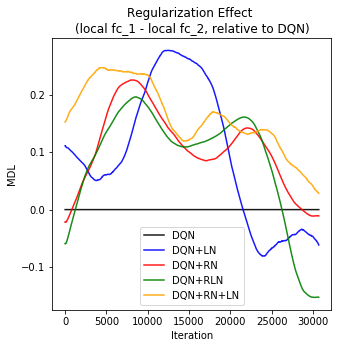

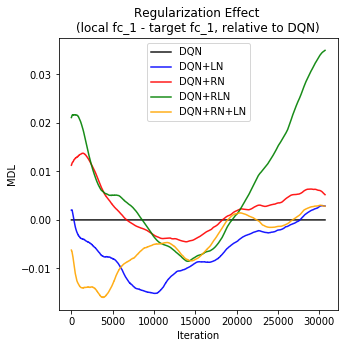

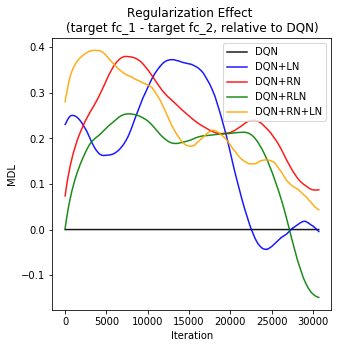

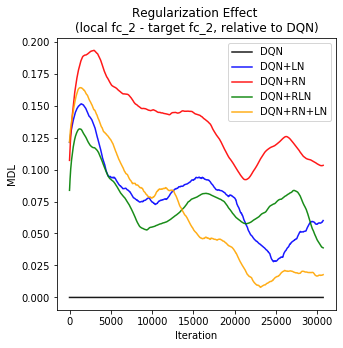

In [3]:
# MDL_local1 = np.array(np.load('./scores/carpole_dqn_mdl_local.npy',allow_pickle=True))
# MDL_target1 = np.array(np.load('./scores/carpole_dqn_mdl_target.npy',allow_pickle=True))
# MDL_local2 = np.array(np.load('./scores/carpole_dqnln_mdl_local.npy',allow_pickle=True))
# MDL_target2 = np.array(np.load('./scores/carpole_dqnln_mdl_target.npy',allow_pickle=True))
# MDL_local3 = np.array(np.load('./scores/carpole_dqnrn_mdl_local.npy',allow_pickle=True))
# MDL_target3 = np.array(np.load('./scores/carpole_dqnrn_mdl_target.npy',allow_pickle=True))
# MDL_local4 = np.array(np.load('./scores/carpole_dqnrln_mdl_local.npy',allow_pickle=True))
# MDL_target4 = np.array(np.load('./scores/carpole_dqnrln_mdl_target.npy',allow_pickle=True))
# MDL_local5 = np.array(np.load('./scores/carpole_dqnrnln_mdl_local.npy',allow_pickle=True))
# MDL_target5 = np.array(np.load('./scores/carpole_dqnrnln_mdl_target.npy',allow_pickle=True))

# MA = 500
# maxT = np.min([MDL_local1.shape[0],MDL_local2.shape[0],MDL_local3.shape[0],MDL_local4.shape[0],MDL_local5.shape[0]])
# T = np.arange(maxT-MA+1)

# l1_fc1 = pd.Series(MDL_local1[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# l2_fc1 = pd.Series(MDL_local2[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# l3_fc1 = pd.Series(MDL_local3[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# l4_fc1 = pd.Series(MDL_local4[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# l5_fc1 = pd.Series(MDL_local5[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# t1_fc1 = pd.Series(MDL_target1[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# t2_fc1 = pd.Series(MDL_target2[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# t3_fc1 = pd.Series(MDL_target3[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# t4_fc1 = pd.Series(MDL_target4[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# t5_fc1 = pd.Series(MDL_target5[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# l1_fc2 = pd.Series(MDL_local1[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
# l2_fc2 = pd.Series(MDL_local2[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
# l3_fc2 = pd.Series(MDL_local3[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
# l4_fc2 = pd.Series(MDL_local4[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
# l5_fc2 = pd.Series(MDL_local5[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
# t1_fc2 = pd.Series(MDL_target1[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
# t2_fc2 = pd.Series(MDL_target2[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
# t3_fc2 = pd.Series(MDL_target3[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
# t4_fc2 = pd.Series(MDL_target4[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
# t5_fc2 = pd.Series(MDL_target5[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values

alpha = 0.9

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

ax.plot(T, l1_fc1-l1_fc2-(l1_fc1-l1_fc2),label='DQN',color='black',alpha=alpha)
ax.plot(T, l2_fc1-l2_fc2-(l1_fc1-l1_fc2),label='DQN+LN',color='blue',alpha=alpha)
ax.plot(T, l3_fc1-l3_fc2-(l1_fc1-l1_fc2),label='DQN+RN',color='red',alpha=alpha)
ax.plot(T, l4_fc1-l4_fc2-(l1_fc1-l1_fc2),label='DQN+RLN',color='green',alpha=alpha)
ax.plot(T, l5_fc1-l5_fc2-(l1_fc1-l1_fc2),label='DQN+RN+LN',color='orange',alpha=alpha)

ax.set_ylabel('MDL')
ax.set_xlabel('Iteration')
ax.legend()
ax.set_title('Regularization Effect \n(local fc_1 - local fc_2, relative to DQN)')

fig.savefig('uam_carpole_local_diff_relative.png',layout='tight')


fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

ax.plot(T, l1_fc1-t1_fc1-(l1_fc1-t1_fc1),label='DQN',color='black',alpha=alpha)
ax.plot(T, l2_fc1-t2_fc1-(l1_fc1-t1_fc1),label='DQN+LN',color='blue',alpha=alpha)
ax.plot(T, l3_fc1-t3_fc1-(l1_fc1-t1_fc1),label='DQN+RN',color='red',alpha=alpha)
ax.plot(T, l4_fc1-t4_fc1-(l1_fc1-t1_fc1),label='DQN+RLN',color='green',alpha=alpha)
ax.plot(T, l5_fc1-t5_fc1-(l1_fc1-t1_fc1),label='DQN+RN+LN',color='orange',alpha=alpha)

ax.set_ylabel('MDL')
ax.set_xlabel('Iteration')
ax.legend()
ax.set_title('Regularization Effect \n(local fc_1 - target fc_1, relative to DQN)')

fig.savefig('uam_carpole_local_target_fc_1_relative.png',layout='tight')

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

ax.plot(T, t1_fc1-t1_fc2-(t1_fc1-t1_fc2),label='DQN',color='black',alpha=alpha)
ax.plot(T, t2_fc1-t2_fc2-(t1_fc1-t1_fc2),label='DQN+LN',color='blue',alpha=alpha)
ax.plot(T, t3_fc1-t3_fc2-(t1_fc1-t1_fc2),label='DQN+RN',color='red',alpha=alpha)
ax.plot(T, t4_fc1-t4_fc2-(t1_fc1-t1_fc2),label='DQN+RLN',color='green',alpha=alpha)
ax.plot(T, t5_fc1-t5_fc2-(t1_fc1-t1_fc2),label='DQN+RN+LN',color='orange',alpha=alpha)

ax.set_ylabel('MDL')
ax.set_xlabel('Iteration')
ax.legend()
ax.set_title('Regularization Effect \n(target fc_1 - target fc_2, relative to DQN)')

fig.savefig('uam_carpole_target_diff_relative.png',layout='tight')


fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

ax.plot(T, l1_fc2-t1_fc2-(l1_fc2-t1_fc2),label='DQN',color='black',alpha=alpha)
ax.plot(T, l2_fc2-t2_fc2-(l1_fc2-t1_fc2),label='DQN+LN',color='blue',alpha=alpha)
ax.plot(T, l3_fc2-t3_fc2-(l1_fc2-t1_fc2),label='DQN+RN',color='red',alpha=alpha)
ax.plot(T, l4_fc2-t4_fc2-(l1_fc2-t1_fc2),label='DQN+RLN',color='green',alpha=alpha)
ax.plot(T, l5_fc2-t5_fc2-(l1_fc2-t1_fc2),label='DQN+RN+LN',color='orange',alpha=alpha)

ax.set_ylabel('MDL')
ax.set_xlabel('Iteration')
ax.legend()
ax.set_title('Regularization Effect \n(local fc_2 - target fc_2, relative to DQN)')

fig.savefig('uam_carpole_local_target_fc_2_relative.png',layout='tight')



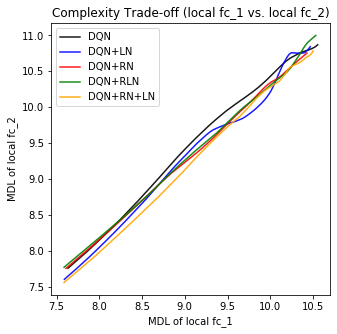

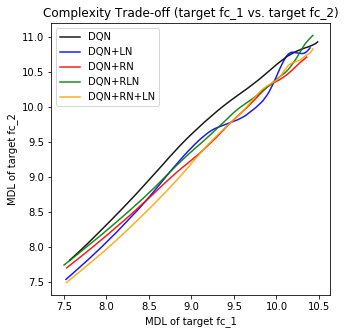

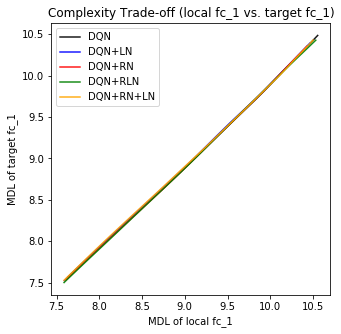

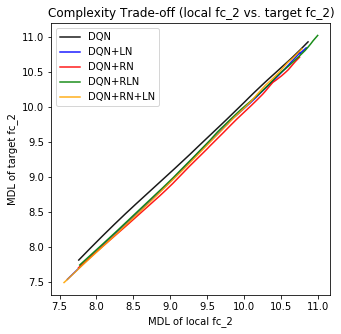

In [74]:
# MDL_local1 = np.array(np.load('./scores/carpole_dqn_mdl_local.npy',allow_pickle=True))
# MDL_target1 = np.array(np.load('./scores/carpole_dqn_mdl_target.npy',allow_pickle=True))
# MDL_local2 = np.array(np.load('./scores/carpole_dqnln_mdl_local.npy',allow_pickle=True))
# MDL_target2 = np.array(np.load('./scores/carpole_dqnln_mdl_target.npy',allow_pickle=True))
# MDL_local3 = np.array(np.load('./scores/carpole_dqnrn_mdl_local.npy',allow_pickle=True))
# MDL_target3 = np.array(np.load('./scores/carpole_dqnrn_mdl_target.npy',allow_pickle=True))
# MDL_local4 = np.array(np.load('./scores/carpole_dqnrln_mdl_local.npy',allow_pickle=True))
# MDL_target4 = np.array(np.load('./scores/carpole_dqnrln_mdl_target.npy',allow_pickle=True))
# MDL_local5 = np.array(np.load('./scores/carpole_dqnrnln_mdl_local.npy',allow_pickle=True))
# MDL_target5 = np.array(np.load('./scores/carpole_dqnrnln_mdl_target.npy',allow_pickle=True))

# MA = 500
# maxT = np.min([MDL_local1.shape[0],MDL_local2.shape[0],MDL_local3.shape[0],MDL_local4.shape[0],MDL_local5.shape[0]])
# T = np.arange(maxT-MA+1)

# l1_fc1 = pd.Series(MDL_local1[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# l2_fc1 = pd.Series(MDL_local2[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# l3_fc1 = pd.Series(MDL_local3[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# l4_fc1 = pd.Series(MDL_local4[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# l5_fc1 = pd.Series(MDL_local5[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# t1_fc1 = pd.Series(MDL_target1[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# t2_fc1 = pd.Series(MDL_target2[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# t3_fc1 = pd.Series(MDL_target3[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# t4_fc1 = pd.Series(MDL_target4[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# t5_fc1 = pd.Series(MDL_target5[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# l1_fc2 = pd.Series(MDL_local1[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
# l2_fc2 = pd.Series(MDL_local2[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
# l3_fc2 = pd.Series(MDL_local3[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
# l4_fc2 = pd.Series(MDL_local4[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
# l5_fc2 = pd.Series(MDL_local5[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
# t1_fc2 = pd.Series(MDL_target1[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
# t2_fc2 = pd.Series(MDL_target2[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
# t3_fc2 = pd.Series(MDL_target3[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
# t4_fc2 = pd.Series(MDL_target4[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
# t5_fc2 = pd.Series(MDL_target5[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values


alpha = 0.9                       
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

ax.plot(l1_fc1,l1_fc2,label='DQN',color='black',alpha=alpha)
ax.plot(l2_fc1,l2_fc2,label='DQN+LN',color='blue',alpha=alpha)
ax.plot(l3_fc1,l3_fc2,label='DQN+RN',color='red',alpha=alpha)
ax.plot(l4_fc1,l4_fc2,label='DQN+RLN',color='green',alpha=alpha)
ax.plot(l5_fc1,l5_fc2,label='DQN+RN+LN',color='orange',alpha=alpha)

ax.set_ylabel('MDL of local fc_2')
ax.set_xlabel('MDL of local fc_1')
ax.legend()
ax.set_title('Complexity Trade-off (local fc_1 vs. local fc_2)')

fig.savefig('uam_carpole_local_fc_1_v_local_fc_2.png',layout='tight')


fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

ax.plot(t1_fc1,t1_fc2,label='DQN',color='black',alpha=alpha)
ax.plot(t2_fc1,t2_fc2,label='DQN+LN',color='blue',alpha=alpha)
ax.plot(t3_fc1,t3_fc2,label='DQN+RN',color='red',alpha=alpha)
ax.plot(t4_fc1,t4_fc2,label='DQN+RLN',color='green',alpha=alpha)
ax.plot(t5_fc1,t5_fc2,label='DQN+RN+LN',color='orange',alpha=alpha)

ax.set_ylabel('MDL of target fc_2')
ax.set_xlabel('MDL of target fc_1')
ax.legend()
ax.set_title('Complexity Trade-off (target fc_1 vs. target fc_2)')

fig.savefig('uam_carpole_target_fc_1_v_target_fc_2.png',layout='tight')

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

ax.plot(l1_fc1,t1_fc1,label='DQN',color='black',alpha=alpha)
ax.plot(l2_fc1,t2_fc1,label='DQN+LN',color='blue',alpha=alpha)
ax.plot(l3_fc1,t3_fc1,label='DQN+RN',color='red',alpha=alpha)
ax.plot(l4_fc1,t4_fc1,label='DQN+RLN',color='green',alpha=alpha)
ax.plot(l5_fc1,t5_fc1,label='DQN+RN+LN',color='orange',alpha=alpha)

ax.set_ylabel('MDL of target fc_1')
ax.set_xlabel('MDL of local fc_1')
ax.legend()
ax.set_title('Complexity Trade-off (local fc_1 vs. target fc_1)')

fig.savefig('uam_carpole_local_fc_1_v_target_fc_1.png',layout='tight')


fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

ax.plot(l1_fc2,t1_fc2,label='DQN',color='black',alpha=alpha)
ax.plot(l2_fc2,t2_fc2,label='DQN+LN',color='blue',alpha=alpha)
ax.plot(l3_fc2,t3_fc2,label='DQN+RN',color='red',alpha=alpha)
ax.plot(l4_fc2,t4_fc2,label='DQN+RLN',color='green',alpha=alpha)
ax.plot(l5_fc2,t5_fc2,label='DQN+RN+LN',color='orange',alpha=alpha)

ax.set_ylabel('MDL of target fc_2')
ax.set_xlabel('MDL of local fc_2')
ax.legend()
ax.set_title('Complexity Trade-off (local fc_2 vs. target fc_2)')

fig.savefig('uam_carpole_local_fc_2_v_target_fc_2.png',layout='tight')

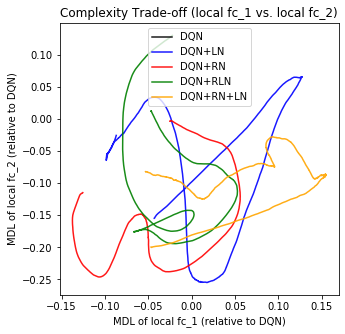

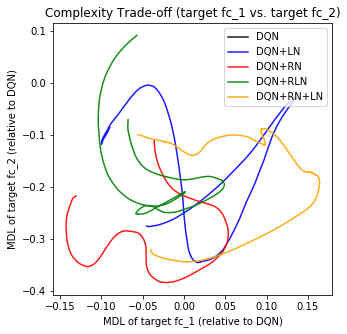

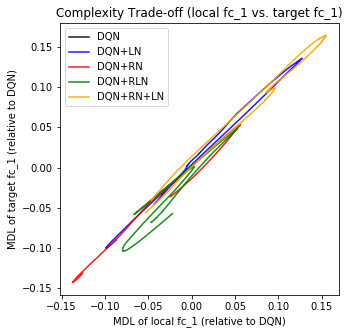

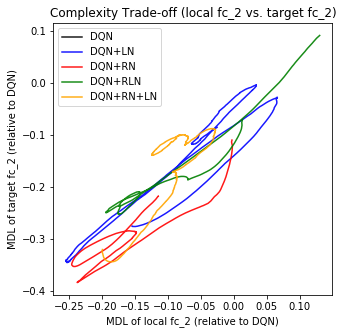

In [75]:
# MDL_local1 = np.array(np.load('./scores/carpole_dqn_mdl_local.npy',allow_pickle=True))
# MDL_target1 = np.array(np.load('./scores/carpole_dqn_mdl_target.npy',allow_pickle=True))
# MDL_local2 = np.array(np.load('./scores/carpole_dqnln_mdl_local.npy',allow_pickle=True))
# MDL_target2 = np.array(np.load('./scores/carpole_dqnln_mdl_target.npy',allow_pickle=True))
# MDL_local3 = np.array(np.load('./scores/carpole_dqnrn_mdl_local.npy',allow_pickle=True))
# MDL_target3 = np.array(np.load('./scores/carpole_dqnrn_mdl_target.npy',allow_pickle=True))
# MDL_local4 = np.array(np.load('./scores/carpole_dqnrln_mdl_local.npy',allow_pickle=True))
# MDL_target4 = np.array(np.load('./scores/carpole_dqnrln_mdl_target.npy',allow_pickle=True))
# MDL_local5 = np.array(np.load('./scores/carpole_dqnrnln_mdl_local.npy',allow_pickle=True))
# MDL_target5 = np.array(np.load('./scores/carpole_dqnrnln_mdl_target.npy',allow_pickle=True))

# MA = 500
# maxT = np.min([MDL_local1.shape[0],MDL_local2.shape[0],MDL_local3.shape[0],MDL_local4.shape[0],MDL_local5.shape[0]])
# T = np.arange(maxT-MA+1)

# l1_fc1 = pd.Series(MDL_local1[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# l2_fc1 = pd.Series(MDL_local2[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# l3_fc1 = pd.Series(MDL_local3[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# l4_fc1 = pd.Series(MDL_local4[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# l5_fc1 = pd.Series(MDL_local5[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# t1_fc1 = pd.Series(MDL_target1[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# t2_fc1 = pd.Series(MDL_target2[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# t3_fc1 = pd.Series(MDL_target3[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# t4_fc1 = pd.Series(MDL_target4[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# t5_fc1 = pd.Series(MDL_target5[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# l1_fc2 = pd.Series(MDL_local1[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
# l2_fc2 = pd.Series(MDL_local2[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
# l3_fc2 = pd.Series(MDL_local3[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
# l4_fc2 = pd.Series(MDL_local4[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
# l5_fc2 = pd.Series(MDL_local5[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
# t1_fc2 = pd.Series(MDL_target1[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
# t2_fc2 = pd.Series(MDL_target2[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
# t3_fc2 = pd.Series(MDL_target3[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
# t4_fc2 = pd.Series(MDL_target4[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
# t5_fc2 = pd.Series(MDL_target5[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values

alpha = 0.9                       
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

ax.plot(l1_fc1-l1_fc1,l1_fc2-l1_fc2,label='DQN',color='black',alpha=alpha)
ax.plot(l2_fc1-l1_fc1,l2_fc2-l1_fc2,label='DQN+LN',color='blue',alpha=alpha)
ax.plot(l3_fc1-l1_fc1,l3_fc2-l1_fc2,label='DQN+RN',color='red',alpha=alpha)
ax.plot(l4_fc1-l1_fc1,l4_fc2-l1_fc2,label='DQN+RLN',color='green',alpha=alpha)
ax.plot(l5_fc1-l1_fc1,l5_fc2-l1_fc2,label='DQN+RN+LN',color='orange',alpha=alpha)

ax.set_ylabel('MDL of local fc_2 (relative to DQN)')
ax.set_xlabel('MDL of local fc_1 (relative to DQN)')
ax.legend()
ax.set_title('Complexity Trade-off (local fc_1 vs. local fc_2)')

fig.savefig('uam_carpole_local_fc_1_v_local_fc_2_relative.png',layout='tight')


fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

ax.plot(t1_fc1-t1_fc1,t1_fc2-t1_fc2,label='DQN',color='black',alpha=alpha)
ax.plot(t2_fc1-t1_fc1,t2_fc2-t1_fc2,label='DQN+LN',color='blue',alpha=alpha)
ax.plot(t3_fc1-t1_fc1,t3_fc2-t1_fc2,label='DQN+RN',color='red',alpha=alpha)
ax.plot(t4_fc1-t1_fc1,t4_fc2-t1_fc2,label='DQN+RLN',color='green',alpha=alpha)
ax.plot(t5_fc1-t1_fc1,t5_fc2-t1_fc2,label='DQN+RN+LN',color='orange',alpha=alpha)

ax.set_ylabel('MDL of target fc_2 (relative to DQN)')
ax.set_xlabel('MDL of target fc_1 (relative to DQN)')
ax.legend()
ax.set_title('Complexity Trade-off (target fc_1 vs. target fc_2)')

fig.savefig('uam_carpole_target_fc_1_v_target_fc_2_relative.png',layout='tight')

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

ax.plot(l1_fc1-l1_fc1,t1_fc1-t1_fc1,label='DQN',color='black',alpha=alpha)
ax.plot(l2_fc1-l1_fc1,t2_fc1-t1_fc1,label='DQN+LN',color='blue',alpha=alpha)
ax.plot(l3_fc1-l1_fc1,t3_fc1-t1_fc1,label='DQN+RN',color='red',alpha=alpha)
ax.plot(l4_fc1-l1_fc1,t4_fc1-t1_fc1,label='DQN+RLN',color='green',alpha=alpha)
ax.plot(l5_fc1-l1_fc1,t5_fc1-t1_fc1,label='DQN+RN+LN',color='orange',alpha=alpha)

ax.set_ylabel('MDL of target fc_1 (relative to DQN)')
ax.set_xlabel('MDL of local fc_1 (relative to DQN)')
ax.legend()
ax.set_title('Complexity Trade-off (local fc_1 vs. target fc_1)')

fig.savefig('uam_carpole_local_fc_1_v_target_fc_1_relative.png',layout='tight')


fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

ax.plot(l1_fc2-l1_fc2,t1_fc2-t1_fc2,label='DQN',color='black',alpha=alpha)
ax.plot(l2_fc2-l1_fc2,t2_fc2-t1_fc2,label='DQN+LN',color='blue',alpha=alpha)
ax.plot(l3_fc2-l1_fc2,t3_fc2-t1_fc2,label='DQN+RN',color='red',alpha=alpha)
ax.plot(l4_fc2-l1_fc2,t4_fc2-t1_fc2,label='DQN+RLN',color='green',alpha=alpha)
ax.plot(l5_fc2-l1_fc2,t5_fc2-t1_fc2,label='DQN+RN+LN',color='orange',alpha=alpha)

ax.set_ylabel('MDL of target fc_2 (relative to DQN)')
ax.set_xlabel('MDL of local fc_2 (relative to DQN)')
ax.legend()
ax.set_title('Complexity Trade-off (local fc_2 vs. target fc_2)')

fig.savefig('uam_carpole_local_fc_2_v_target_fc_2_relative.png',layout='tight')

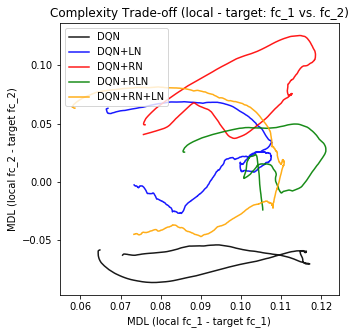

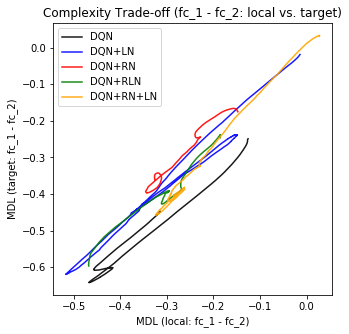

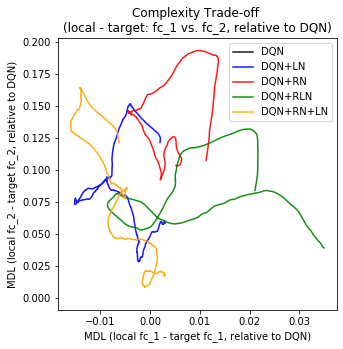

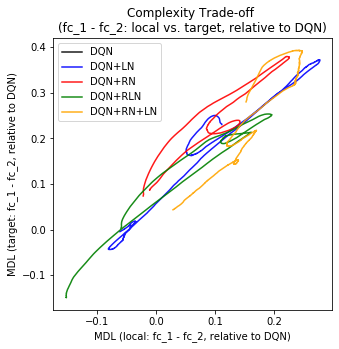

In [76]:
# MDL_local1 = np.array(np.load('./scores/carpole_dqn_mdl_local.npy',allow_pickle=True))
# MDL_target1 = np.array(np.load('./scores/carpole_dqn_mdl_target.npy',allow_pickle=True))
# MDL_local2 = np.array(np.load('./scores/carpole_dqnln_mdl_local.npy',allow_pickle=True))
# MDL_target2 = np.array(np.load('./scores/carpole_dqnln_mdl_target.npy',allow_pickle=True))
# MDL_local3 = np.array(np.load('./scores/carpole_dqnrn_mdl_local.npy',allow_pickle=True))
# MDL_target3 = np.array(np.load('./scores/carpole_dqnrn_mdl_target.npy',allow_pickle=True))
# MDL_local4 = np.array(np.load('./scores/carpole_dqnrln_mdl_local.npy',allow_pickle=True))
# MDL_target4 = np.array(np.load('./scores/carpole_dqnrln_mdl_target.npy',allow_pickle=True))
# MDL_local5 = np.array(np.load('./scores/carpole_dqnrnln_mdl_local.npy',allow_pickle=True))
# MDL_target5 = np.array(np.load('./scores/carpole_dqnrnln_mdl_target.npy',allow_pickle=True))

# MA = 500
# maxT = np.min([MDL_local1.shape[0],MDL_local2.shape[0],MDL_local3.shape[0],MDL_local4.shape[0],MDL_local5.shape[0]])
# T = np.arange(maxT-MA+1)

# l1_fc1 = pd.Series(MDL_local1[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# l2_fc1 = pd.Series(MDL_local2[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# l3_fc1 = pd.Series(MDL_local3[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# l4_fc1 = pd.Series(MDL_local4[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# l5_fc1 = pd.Series(MDL_local5[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# t1_fc1 = pd.Series(MDL_target1[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# t2_fc1 = pd.Series(MDL_target2[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# t3_fc1 = pd.Series(MDL_target3[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# t4_fc1 = pd.Series(MDL_target4[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# t5_fc1 = pd.Series(MDL_target5[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# l1_fc2 = pd.Series(MDL_local1[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
# l2_fc2 = pd.Series(MDL_local2[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
# l3_fc2 = pd.Series(MDL_local3[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
# l4_fc2 = pd.Series(MDL_local4[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
# l5_fc2 = pd.Series(MDL_local5[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
# t1_fc2 = pd.Series(MDL_target1[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
# t2_fc2 = pd.Series(MDL_target2[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
# t3_fc2 = pd.Series(MDL_target3[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
# t4_fc2 = pd.Series(MDL_target4[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
# t5_fc2 = pd.Series(MDL_target5[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values

alpha = 0.9

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

ax.plot(l1_fc1-t1_fc1,l1_fc2-t1_fc2,label='DQN',color='black',alpha=alpha)
ax.plot(l2_fc1-t2_fc1,l2_fc2-t2_fc2,label='DQN+LN',color='blue',alpha=alpha)
ax.plot(l3_fc1-t3_fc1,l3_fc2-t3_fc2,label='DQN+RN',color='red',alpha=alpha)
ax.plot(l4_fc1-t4_fc1,l4_fc2-t4_fc2,label='DQN+RLN',color='green',alpha=alpha)
ax.plot(l5_fc1-t5_fc1,l5_fc2-t5_fc2,label='DQN+RN+LN',color='orange',alpha=alpha)

ax.set_ylabel('MDL (local fc_2 - target fc_2)')
ax.set_xlabel('MDL (local fc_1 - target fc_1)')
ax.legend()
ax.set_title('Complexity Trade-off (local - target: fc_1 vs. fc_2)')

fig.savefig('uam_carpole_diff_fc_1_v_diff_fc_2.png',layout='tight')

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

ax.plot(l1_fc1-l1_fc2,t1_fc1-t1_fc2,label='DQN',color='black',alpha=alpha)
ax.plot(l2_fc1-l2_fc2,t2_fc1-t2_fc2,label='DQN+LN',color='blue',alpha=alpha)
ax.plot(l3_fc1-l3_fc2,t3_fc1-t3_fc2,label='DQN+RN',color='red',alpha=alpha)
ax.plot(l4_fc1-l4_fc2,t4_fc1-t4_fc2,label='DQN+RLN',color='green',alpha=alpha)
ax.plot(l5_fc1-l5_fc2,t5_fc1-t5_fc2,label='DQN+RN+LN',color='orange',alpha=alpha)

ax.set_ylabel('MDL (target: fc_1 - fc_2)')
ax.set_xlabel('MDL (local: fc_1 - fc_2)')
ax.legend()
ax.set_title('Complexity Trade-off (fc_1 - fc_2: local vs. target)')

fig.savefig('uam_carpole_diff_local_v_target.png',layout='tight')


fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

ax.plot(l1_fc1-t1_fc1-(l1_fc1-t1_fc1),l1_fc2-t1_fc2-(l1_fc2-t1_fc2),label='DQN',color='black',alpha=alpha)
ax.plot(l2_fc1-t2_fc1-(l1_fc1-t1_fc1),l2_fc2-t2_fc2-(l1_fc2-t1_fc2),label='DQN+LN',color='blue',alpha=alpha)
ax.plot(l3_fc1-t3_fc1-(l1_fc1-t1_fc1),l3_fc2-t3_fc2-(l1_fc2-t1_fc2),label='DQN+RN',color='red',alpha=alpha)
ax.plot(l4_fc1-t4_fc1-(l1_fc1-t1_fc1),l4_fc2-t4_fc2-(l1_fc2-t1_fc2),label='DQN+RLN',color='green',alpha=alpha)
ax.plot(l5_fc1-t5_fc1-(l1_fc1-t1_fc1),l5_fc2-t5_fc2-(l1_fc2-t1_fc2),label='DQN+RN+LN',color='orange',alpha=alpha)

ax.set_ylabel('MDL (local fc_2 - target fc_2, relative to DQN)')
ax.set_xlabel('MDL (local fc_1 - target fc_1, relative to DQN)')
ax.legend()
ax.set_title('Complexity Trade-off \n(local - target: fc_1 vs. fc_2, relative to DQN)')

fig.savefig('uam_carpole_diff_fc_1_v_diff_fc_2_relative.png',layout='tight')

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

ax.plot(l1_fc1-l1_fc2-(l1_fc1-l1_fc2),t1_fc1-t1_fc2-(t1_fc1-t1_fc2),label='DQN',color='black',alpha=alpha)
ax.plot(l2_fc1-l2_fc2-(l1_fc1-l1_fc2),t2_fc1-t2_fc2-(t1_fc1-t1_fc2),label='DQN+LN',color='blue',alpha=alpha)
ax.plot(l3_fc1-l3_fc2-(l1_fc1-l1_fc2),t3_fc1-t3_fc2-(t1_fc1-t1_fc2),label='DQN+RN',color='red',alpha=alpha)
ax.plot(l4_fc1-l4_fc2-(l1_fc1-l1_fc2),t4_fc1-t4_fc2-(t1_fc1-t1_fc2),label='DQN+RLN',color='green',alpha=alpha)
ax.plot(l5_fc1-l5_fc2-(l1_fc1-l1_fc2),t5_fc1-t5_fc2-(t1_fc1-t1_fc2),label='DQN+RN+LN',color='orange',alpha=alpha)

ax.set_ylabel('MDL (target: fc_1 - fc_2, relative to DQN)')
ax.set_xlabel('MDL (local: fc_1 - fc_2, relative to DQN)')
ax.legend()
ax.set_title('Complexity Trade-off \n(fc_1 - fc_2: local vs. target, relative to DQN)')

fig.savefig('uam_carpole_diff_local_v_target_relative.png',layout='tight')



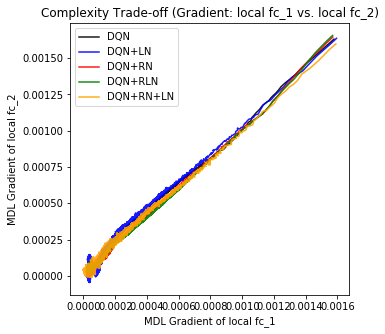

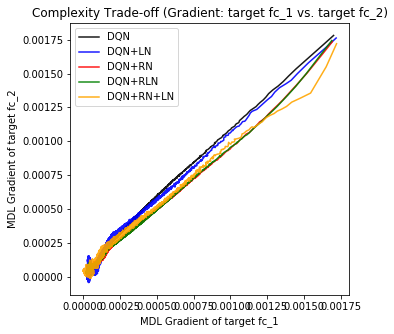

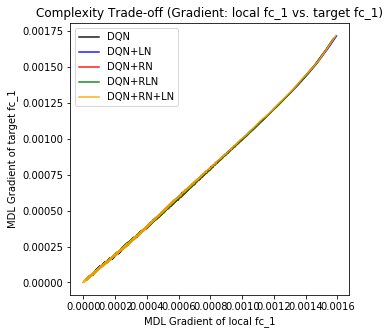

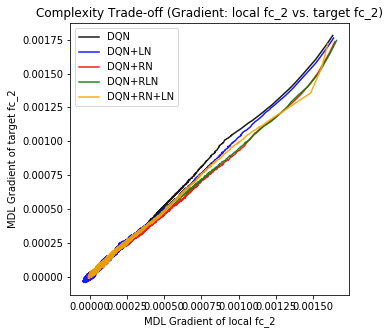

In [77]:
# MDL_local1 = np.array(np.load('./scores/carpole_dqn_mdl_local.npy',allow_pickle=True))
# MDL_target1 = np.array(np.load('./scores/carpole_dqn_mdl_target.npy',allow_pickle=True))
# MDL_local2 = np.array(np.load('./scores/carpole_dqnln_mdl_local.npy',allow_pickle=True))
# MDL_target2 = np.array(np.load('./scores/carpole_dqnln_mdl_target.npy',allow_pickle=True))
# MDL_local3 = np.array(np.load('./scores/carpole_dqnrn_mdl_local.npy',allow_pickle=True))
# MDL_target3 = np.array(np.load('./scores/carpole_dqnrn_mdl_target.npy',allow_pickle=True))
# MDL_local4 = np.array(np.load('./scores/carpole_dqnrln_mdl_local.npy',allow_pickle=True))
# MDL_target4 = np.array(np.load('./scores/carpole_dqnrln_mdl_target.npy',allow_pickle=True))
# MDL_local5 = np.array(np.load('./scores/carpole_dqnrnln_mdl_local.npy',allow_pickle=True))
# MDL_target5 = np.array(np.load('./scores/carpole_dqnrnln_mdl_target.npy',allow_pickle=True))

# MA = 500
# maxT = np.min([MDL_local1.shape[0],MDL_local2.shape[0],MDL_local3.shape[0],MDL_local4.shape[0],MDL_local5.shape[0]])
# T = np.arange(maxT-MA+1)

# l1_fc1 = pd.Series(MDL_local1[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# l2_fc1 = pd.Series(MDL_local2[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# l3_fc1 = pd.Series(MDL_local3[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# l4_fc1 = pd.Series(MDL_local4[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# l5_fc1 = pd.Series(MDL_local5[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# t1_fc1 = pd.Series(MDL_target1[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# t2_fc1 = pd.Series(MDL_target2[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# t3_fc1 = pd.Series(MDL_target3[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# t4_fc1 = pd.Series(MDL_target4[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# t5_fc1 = pd.Series(MDL_target5[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# l1_fc2 = pd.Series(MDL_local1[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
# l2_fc2 = pd.Series(MDL_local2[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
# l3_fc2 = pd.Series(MDL_local3[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
# l4_fc2 = pd.Series(MDL_local4[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
# l5_fc2 = pd.Series(MDL_local5[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
# t1_fc2 = pd.Series(MDL_target1[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
# t2_fc2 = pd.Series(MDL_target2[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
# t3_fc2 = pd.Series(MDL_target3[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
# t4_fc2 = pd.Series(MDL_target4[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
# t5_fc2 = pd.Series(MDL_target5[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values


alpha = 0.9                       
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

ax.plot(np.gradient(l1_fc1),np.gradient(l1_fc2),label='DQN',color='black',alpha=alpha)
ax.plot(np.gradient(l2_fc1),np.gradient(l2_fc2),label='DQN+LN',color='blue',alpha=alpha)
ax.plot(np.gradient(l3_fc1),np.gradient(l3_fc2),label='DQN+RN',color='red',alpha=alpha)
ax.plot(np.gradient(l4_fc1),np.gradient(l4_fc2),label='DQN+RLN',color='green',alpha=alpha)
ax.plot(np.gradient(l5_fc1),np.gradient(l5_fc2),label='DQN+RN+LN',color='orange',alpha=alpha)

ax.set_ylabel('MDL Gradient of local fc_2')
ax.set_xlabel('MDL Gradient of local fc_1')
ax.legend()
ax.set_title('Complexity Trade-off (Gradient: local fc_1 vs. local fc_2)')

fig.savefig('uam_carpole_local_fc_1_v_local_fc_2_slope.png',layout='tight')


fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

ax.plot(np.gradient(t1_fc1),np.gradient(t1_fc2),label='DQN',color='black',alpha=alpha)
ax.plot(np.gradient(t2_fc1),np.gradient(t2_fc2),label='DQN+LN',color='blue',alpha=alpha)
ax.plot(np.gradient(t3_fc1),np.gradient(t3_fc2),label='DQN+RN',color='red',alpha=alpha)
ax.plot(np.gradient(t4_fc1),np.gradient(t4_fc2),label='DQN+RLN',color='green',alpha=alpha)
ax.plot(np.gradient(t5_fc1),np.gradient(t5_fc2),label='DQN+RN+LN',color='orange',alpha=alpha)

ax.set_ylabel('MDL Gradient of target fc_2')
ax.set_xlabel('MDL Gradient of target fc_1')
ax.legend()
ax.set_title('Complexity Trade-off (Gradient: target fc_1 vs. target fc_2)')

fig.savefig('uam_carpole_target_fc_1_v_target_fc_2_slope.png',layout='tight')

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

ax.plot(np.gradient(l1_fc1),np.gradient(t1_fc1),label='DQN',color='black',alpha=alpha)
ax.plot(np.gradient(l2_fc1),np.gradient(t2_fc1),label='DQN+LN',color='blue',alpha=alpha)
ax.plot(np.gradient(l3_fc1),np.gradient(t3_fc1),label='DQN+RN',color='red',alpha=alpha)
ax.plot(np.gradient(l4_fc1),np.gradient(t4_fc1),label='DQN+RLN',color='green',alpha=alpha)
ax.plot(np.gradient(l5_fc1),np.gradient(t5_fc1),label='DQN+RN+LN',color='orange',alpha=alpha)

ax.set_ylabel('MDL Gradient of target fc_1')
ax.set_xlabel('MDL Gradient of local fc_1')
ax.legend()
ax.set_title('Complexity Trade-off (Gradient: local fc_1 vs. target fc_1)')

fig.savefig('uam_carpole_local_fc_1_v_target_fc_1_slope.png',layout='tight')


fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

ax.plot(np.gradient(l1_fc2),np.gradient(t1_fc2),label='DQN',color='black',alpha=alpha)
ax.plot(np.gradient(l2_fc2),np.gradient(t2_fc2),label='DQN+LN',color='blue',alpha=alpha)
ax.plot(np.gradient(l3_fc2),np.gradient(t3_fc2),label='DQN+RN',color='red',alpha=alpha)
ax.plot(np.gradient(l4_fc2),np.gradient(t4_fc2),label='DQN+RLN',color='green',alpha=alpha)
ax.plot(np.gradient(l5_fc2),np.gradient(t5_fc2),label='DQN+RN+LN',color='orange',alpha=alpha)

ax.set_ylabel('MDL Gradient of target fc_2')
ax.set_xlabel('MDL Gradient of local fc_2')
ax.legend()
ax.set_title('Complexity Trade-off (Gradient: local fc_2 vs. target fc_2)')

fig.savefig('uam_carpole_local_fc_2_v_target_fc_2_slope.png',layout='tight')

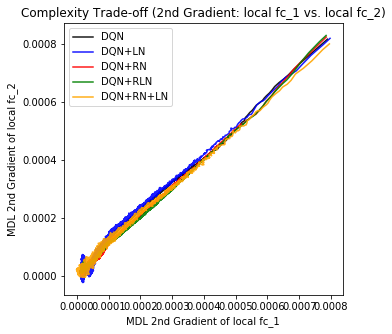

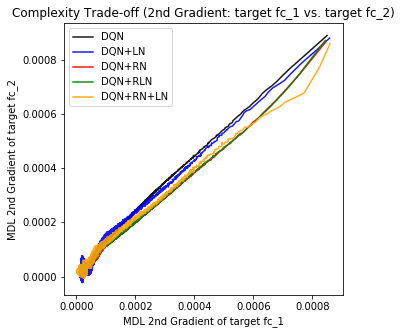

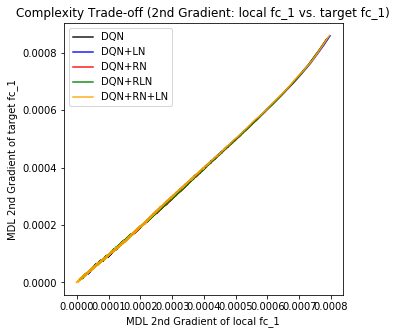

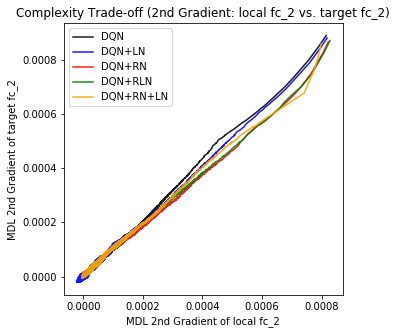

In [78]:
# MDL_local1 = np.array(np.load('./scores/carpole_dqn_mdl_local.npy',allow_pickle=True))
# MDL_target1 = np.array(np.load('./scores/carpole_dqn_mdl_target.npy',allow_pickle=True))
# MDL_local2 = np.array(np.load('./scores/carpole_dqnln_mdl_local.npy',allow_pickle=True))
# MDL_target2 = np.array(np.load('./scores/carpole_dqnln_mdl_target.npy',allow_pickle=True))
# MDL_local3 = np.array(np.load('./scores/carpole_dqnrn_mdl_local.npy',allow_pickle=True))
# MDL_target3 = np.array(np.load('./scores/carpole_dqnrn_mdl_target.npy',allow_pickle=True))
# MDL_local4 = np.array(np.load('./scores/carpole_dqnrln_mdl_local.npy',allow_pickle=True))
# MDL_target4 = np.array(np.load('./scores/carpole_dqnrln_mdl_target.npy',allow_pickle=True))
# MDL_local5 = np.array(np.load('./scores/carpole_dqnrnln_mdl_local.npy',allow_pickle=True))
# MDL_target5 = np.array(np.load('./scores/carpole_dqnrnln_mdl_target.npy',allow_pickle=True))

# MA = 500
# maxT = np.min([MDL_local1.shape[0],MDL_local2.shape[0],MDL_local3.shape[0],MDL_local4.shape[0],MDL_local5.shape[0]])
# T = np.arange(maxT-MA+1)

# l1_fc1 = pd.Series(MDL_local1[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# l2_fc1 = pd.Series(MDL_local2[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# l3_fc1 = pd.Series(MDL_local3[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# l4_fc1 = pd.Series(MDL_local4[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# l5_fc1 = pd.Series(MDL_local5[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# t1_fc1 = pd.Series(MDL_target1[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# t2_fc1 = pd.Series(MDL_target2[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# t3_fc1 = pd.Series(MDL_target3[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# t4_fc1 = pd.Series(MDL_target4[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# t5_fc1 = pd.Series(MDL_target5[:maxT,1]).rolling(window=MA).mean().iloc[MA-1:].values
# l1_fc2 = pd.Series(MDL_local1[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
# l2_fc2 = pd.Series(MDL_local2[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
# l3_fc2 = pd.Series(MDL_local3[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
# l4_fc2 = pd.Series(MDL_local4[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
# l5_fc2 = pd.Series(MDL_local5[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
# t1_fc2 = pd.Series(MDL_target1[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
# t2_fc2 = pd.Series(MDL_target2[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
# t3_fc2 = pd.Series(MDL_target3[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
# t4_fc2 = pd.Series(MDL_target4[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values
# t5_fc2 = pd.Series(MDL_target5[:maxT,2]).rolling(window=MA).mean().iloc[MA-1:].values


alpha = 0.9                       
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

ax.plot(np.gradient(l1_fc1,2),np.gradient(l1_fc2,2),label='DQN',color='black',alpha=alpha)
ax.plot(np.gradient(l2_fc1,2),np.gradient(l2_fc2,2),label='DQN+LN',color='blue',alpha=alpha)
ax.plot(np.gradient(l3_fc1,2),np.gradient(l3_fc2,2),label='DQN+RN',color='red',alpha=alpha)
ax.plot(np.gradient(l4_fc1,2),np.gradient(l4_fc2,2),label='DQN+RLN',color='green',alpha=alpha)
ax.plot(np.gradient(l5_fc1,2),np.gradient(l5_fc2,2),label='DQN+RN+LN',color='orange',alpha=alpha)

ax.set_ylabel('MDL 2nd Gradient of local fc_2')
ax.set_xlabel('MDL 2nd Gradient of local fc_1')
ax.legend()
ax.set_title('Complexity Trade-off (2nd Gradient: local fc_1 vs. local fc_2)')

fig.savefig('uam_carpole_local_fc_1_v_local_fc_2_2nd_slope.png',layout='tight')


fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

ax.plot(np.gradient(t1_fc1,2),np.gradient(t1_fc2,2),label='DQN',color='black',alpha=alpha)
ax.plot(np.gradient(t2_fc1,2),np.gradient(t2_fc2,2),label='DQN+LN',color='blue',alpha=alpha)
ax.plot(np.gradient(t3_fc1,2),np.gradient(t3_fc2,2),label='DQN+RN',color='red',alpha=alpha)
ax.plot(np.gradient(t4_fc1,2),np.gradient(t4_fc2,2),label='DQN+RLN',color='green',alpha=alpha)
ax.plot(np.gradient(t5_fc1,2),np.gradient(t5_fc2,2),label='DQN+RN+LN',color='orange',alpha=alpha)

ax.set_ylabel('MDL 2nd Gradient of target fc_2')
ax.set_xlabel('MDL 2nd Gradient of target fc_1')
ax.legend()
ax.set_title('Complexity Trade-off (2nd Gradient: target fc_1 vs. target fc_2)')

fig.savefig('uam_carpole_target_fc_1_v_target_fc_2_2nd_slope.png',layout='tight')

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

ax.plot(np.gradient(l1_fc1,2),np.gradient(t1_fc1,2),label='DQN',color='black',alpha=alpha)
ax.plot(np.gradient(l2_fc1,2),np.gradient(t2_fc1,2),label='DQN+LN',color='blue',alpha=alpha)
ax.plot(np.gradient(l3_fc1,2),np.gradient(t3_fc1,2),label='DQN+RN',color='red',alpha=alpha)
ax.plot(np.gradient(l4_fc1,2),np.gradient(t4_fc1,2),label='DQN+RLN',color='green',alpha=alpha)
ax.plot(np.gradient(l5_fc1,2),np.gradient(t5_fc1,2),label='DQN+RN+LN',color='orange',alpha=alpha)

ax.set_ylabel('MDL 2nd Gradient of target fc_1')
ax.set_xlabel('MDL 2nd Gradient of local fc_1')
ax.legend()
ax.set_title('Complexity Trade-off (2nd Gradient: local fc_1 vs. target fc_1)')

fig.savefig('uam_carpole_local_fc_1_v_target_fc_1_2nd_slope.png',layout='tight')


fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

ax.plot(np.gradient(l1_fc2,2),np.gradient(t1_fc2,2),label='DQN',color='black',alpha=alpha)
ax.plot(np.gradient(l2_fc2,2),np.gradient(t2_fc2,2),label='DQN+LN',color='blue',alpha=alpha)
ax.plot(np.gradient(l3_fc2,2),np.gradient(t3_fc2,2),label='DQN+RN',color='red',alpha=alpha)
ax.plot(np.gradient(l4_fc2,2),np.gradient(t4_fc2,2),label='DQN+RLN',color='green',alpha=alpha)
ax.plot(np.gradient(l5_fc2,2),np.gradient(t5_fc2,2),label='DQN+RN+LN',color='orange',alpha=alpha)

ax.set_ylabel('MDL 2nd Gradient of target fc_2')
ax.set_xlabel('MDL 2nd Gradient of local fc_2')
ax.legend()
ax.set_title('Complexity Trade-off (2nd Gradient: local fc_2 vs. target fc_2)')

fig.savefig('uam_carpole_local_fc_2_v_target_fc_2_2nd_slope.png',layout='tight')